<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
import tensorflow as tf
tf.random.set_seed(seed=42)

x = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs=x)
y = tf.keras.layers.Reshape(target_shape=(784,))(inputs=h)
preprocessing_model = tf.keras.Model(inputs=x, outputs=y)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [2]:
import tensorflow as tf
tf.random.set_seed(seed=42)

x = tf.keras.Input(shape=(784,))
h = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=x)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)
y = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(inputs=h)
training_model = tf.keras.Model(inputs=x, outputs=y)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
]

@tf.function
def train_step(model, x, y):
    trainable_vars = model.trainable_variables
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
        grads = tape.gradient(target=loss,
            sources=trainable_vars)
    optimizer.apply_gradients(grads_and_vars=zip(
        grads, trainable_vars))

    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function
def test_step(model, x, y):
    y_pred = model(inputs=x)
    loss = loss_fn(y_true=y, y_pred=y_pred)

    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f"test_{m.name}": m.result() for m in metrics}

Training duration: 35s


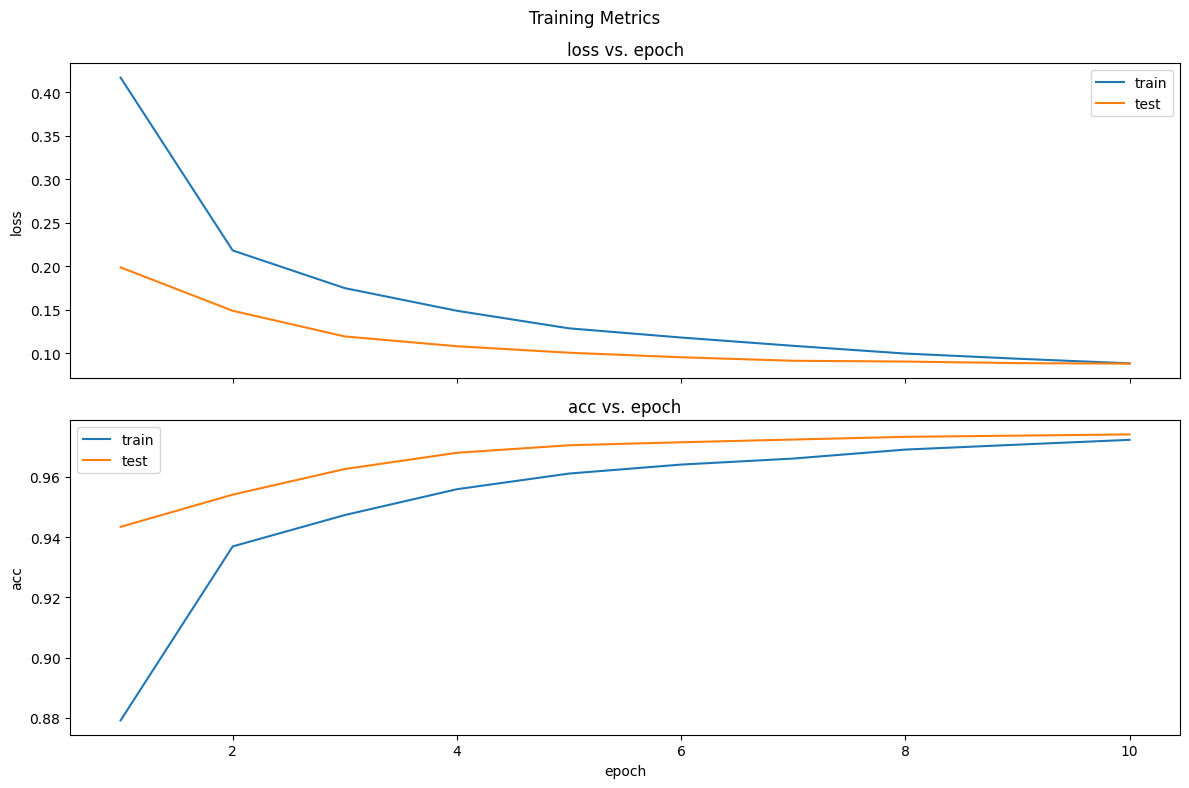

In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

start_time = time.time()
num_epochs = 10
history = []
for epoch in range(num_epochs):
    for x, y in ds_train:
        metric = train_step(model=training_model, x=x, y=y)
    logs = {k: v.numpy() for k, v in metric.items()}
    for m in metrics:
        m.reset_state()

    for x, y in ds_test:
        metric = test_step(model=training_model, x=x, y=y)
    logs.update({k: v.numpy() for k, v in metric.items()})
    history.append(logs)
    for m in metrics:
        m.reset_state()

print("Training duration: %2.fs"%(time.time() - start_time))
df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
axes[1].set_xlabel(xlabel="epoch")
for ax, m in zip(axes, ["loss", "acc"]):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x="epoch", y=f"train_{m}")
    sns.lineplot(ax=ax, data=df_history, label="test",
        x="epoch", y=f"test_{m}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

In [4]:
import tensorflow as tf
tf.random.set_seed(seed=42)
import os
import numpy as np

x = preprocessing_model.input
y = training_model(preprocessing_model(x))
inference_model = tf.keras.Model(inputs=x, outputs=y)

os.makedirs("models", exist_ok=True)
model_path = "models/inference.keras"
inference_model.save(filepath=model_path)
inference_model = tf.keras.models.load_model(filepath=model_path)

idx = 97
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
y_pred = inference_model(inputs=x_pred)
print("y_true:", y_test[idx], "y_pred:", np.argmax(y_pred))

y_true: 7 y_pred: 7


In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("models", exist_ok=True)
ckpt_path = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="val_acc",
    mode="max", save_best_only=True, save_weights_only=True,
    filepath=ckpt_path)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
    mode="min", patience=1, factor=0.9)

training_model.load_weights(ckpt_path)
loss, acc = training_model.evaluate(x=ds_test, verbose=0)
print(f"Test: loss={loss:.2f}, acc={acc:.2f}")